# Programming Computer Vision with Python

** Utility Functions **

In [84]:
from PIL import Image
from pylab import *
import os
import os.path

global all_images
all_images = []
global img_path
img_path = 'PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp'
all_image_root = 'PH2Dataset/PH2 Dataset images'

#gather all images in all_image_root and store them in all_images
def gather_images():
    for dirpath, dirnames, filenames in os.walk(all_image_root):
        for filename in [f for f in filenames if ( f.endswith(".bmp") and "_" not in f  )]:
            all_images.append(os.path.join(dirpath, filename))

gather_images()
       

def imresize(im,sz):
    """ Resize an image array using PIL. """
    pil_im = Image.fromarray(uint8(im))
    return array(pil_im.resize(sz))


def histeq(im, nbr_bins=256):
    """ Histogram equalization of a grayscal image. """
    # get image histogram

    imhist, bins = histogram(im.flatten(), nbr_bins, normed=True)
    cdf = imhist.cumsum()  # cumulative distribution function
    cdf = 255 * cdf / cdf[-1]  # normalize

    # use linear interpolation of cdf to find new pixel values
    im2 = interp(im.flatten(), bins[:-1], cdf)

    return im2.reshape(im.shape), cdf


def compute_average(imlist):
    """ Compute the average of a list of images. """
    
    # open first image and make into array of type float
    averageim = array(Image.open(imlist[0]), 'f')
    for imname in imlist[1:]: 
        try:
            averageim += array(Image.open(imname)) 
        except:
            print(imname + '...skipped')
            
    averageim /= len(imlist)
    # return average as uint8
    return array(averageim, 'uint8')

## Chapter 1 : Basic Image Handling and Processing

### 1.2 Matplotlib

**Plotting Images, Points, and Lines**

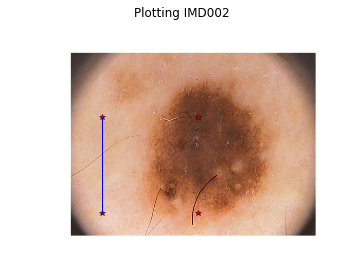

In [6]:
%matplotlib inline

from PIL import Image
from pylab import *

# read image to array
im = array(Image.open(img_path))

# plot the image
imshow(im)

# some points
x = [100, 100, 400, 400]
y = [200, 500, 200, 500]

# plot the points with red star-markers
plot(x, y, 'r*')

# line plot connecting the first two points
plot(x[:2], y[:2])

# add title and show the plot
title('Plotting IMD002')
axis('off')
show()

**Image Contours and Histograms**

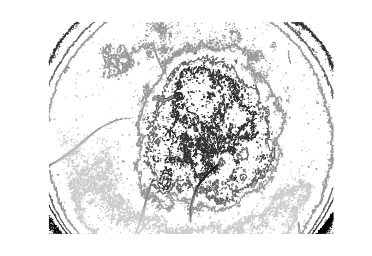

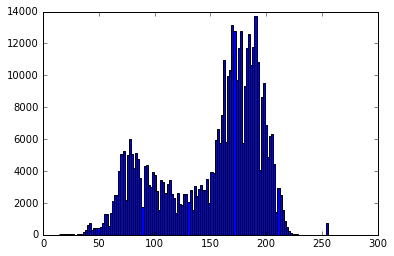

In [7]:
from PIL import Image
from pylab import *

im = array(Image.open(img_path).convert('L'))

figure()
gray()
contour(im, origin='image')
axis('equal')
axis('off')

figure() 
hist(im.flatten(),128) 
show()

### 1.3 NumPy

NumPy adds support for multi-dimensional arrays and matrices, along with a large library of high-level mathematical functions to operate on these arrays.

** Array Image Representation **

In [8]:
im = array(Image.open(img_path))

print(im.shape, im.dtype)

im = array(Image.open(img_path).convert('L'), 'f')
print(im.shape, im.dtype)

(572, 765, 3) uint8
(572, 765) float32


**Graylevel Transforms**

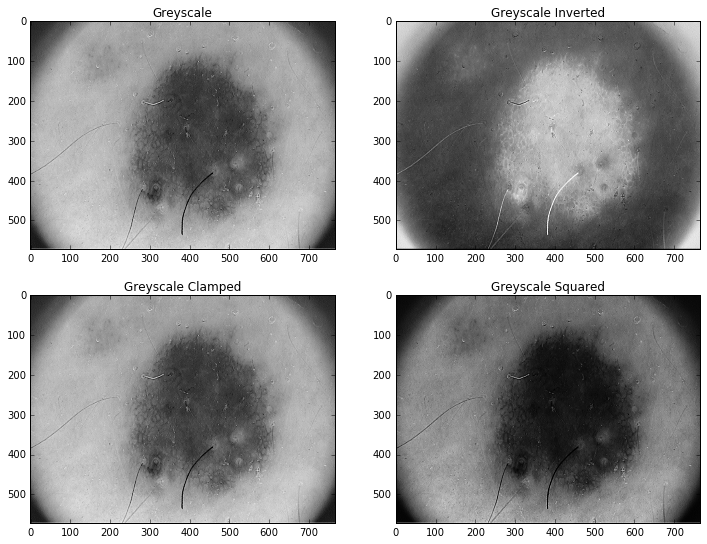

In [9]:
from PIL import Image
from numpy import *
import matplotlib.pyplot as plt

im = array(Image.open(img_path).convert('L'))
im2 = 255 - im #invert image
im3 = (100.0/255) * im + 100 #clamp to interval 100...200
im4 = 255.0 * (im/255.0)**2 # squared

fig = plt.figure(figsize=(12,9), dpi=288) #set figure size


plt.subplot(221)
imshow(im)
title('Greyscale')
plt.subplot(222)
imshow(im2)
title('Greyscale Inverted')
plt.subplot(223)
imshow(im3)
title('Greyscale Clamped')
plt.subplot(224)
imshow(im4)
title('Greyscale Squared')

plt.show()

**Histogram Equalization**

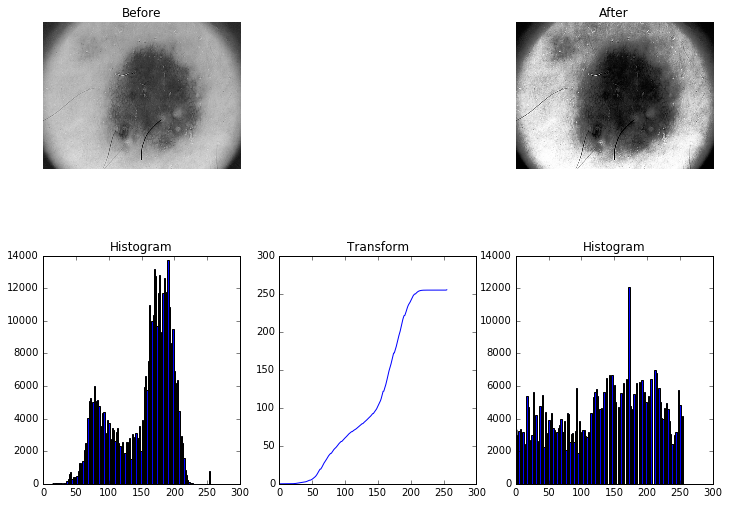

In [10]:
from PIL import Image
from numpy import *


im = array(Image.open(img_path).convert('L'))
im2,cdf = histeq(im)

fig = plt.figure(figsize=(12,9), dpi=288) #set figure size


plt.subplot(231)
title('Before')
imshow(im)
axis('off')

plt.subplot(234)
title('Histogram')
hist(im.flatten(),128) 

plt.subplot(235)
title('Transform')
plot(cdf)


plt.subplot(233)
title('After')
imshow(im2)
axis('off')

plt.subplot(236)
title('Histogram')
hist(im2.flatten(),128) 

plt.show()

*** PCA of Images ***

reduce the dimensionality of an image using Principal Component Analysis

prioritize coordinates in the image

In [11]:
from PIL import Image
from numpy import *

def pca(X):
    """ Principal Component Analysis
        input: X, matrix with training data stored as flattened arrays in rows
        return: projection matrix ( with important dimensions first), variance
        and mean."""
    
    # get dimensions
    num_data, dim = X.shape
    
    # center data
    mean_X = X.mean(axis=0)
    X = X - mean_X
    
    if dim > num_data:
        # PCA - compact trick used
        M = dot(X,X.T) # covariance matrix
        e, EV = linalg.eigh(M)  # eigenvalues and eigenvectors
        tmp = dot(X.T, EV).T # this is the compact trick
        V = tmp[::-1] # reverse since last eigenvectors are the ones we want
        S = sqrt(e)[::-1] # reverse since eigenvalues are in increasing order
        for i in range(V.shape[1]):
            V[:,i] /= S
            
    else:
        # PCA - SVD used
        U, S, V = linalg.svd(X)
        V = V[:num_data] #only makes sense to return the first num_data
    
    # return the projection matrix, the variance and the mean
    return V, S, mean_X

example 1:

/Users/alexandergustafson/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in sqrt


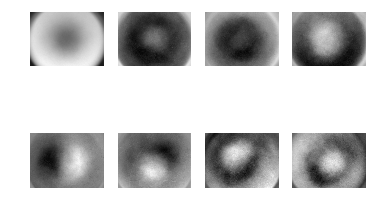

In [12]:
from PIL import Image
from numpy import *
from pylab import *

im = array(Image.open(all_images[0])) # open one image to get the size
m, n = im.shape[0:2]

# create a matrix to store all flattended images, impose a size to all, make greyscale
imgarray = [ array(Image.open(im).convert('L').resize((n,m), Image.ANTIALIAS)).flatten() for im in all_images]
immatrix = array(imgarray,'f')

# perform PCA
V, S, immean = pca(immatrix)

# show some images (mean and 7 first modes)
figure()
gray()
subplot(2,4,1) 
axis('off')
imshow(immean.reshape(m,n) )
for i in range(7):
    subplot(2,4,i+2) 
    axis('off')
    imshow(V[i].reshape(m,n))
show()

### 1.3 SciPy

SciPy contains modules for optimization, linear algebra, integration, interpolation, special functions, FFT, signal and image processing, ODE solvers and other tasks common in science and engineering.

** Blurring Images **

Image is convolved with a Gaussian kernel to create a blurred version

$$I_{\sigma} = I * G_{\sigma}$$

where * indicates convolution and $G_{\sigma}$ is a Gaussian 2D-kernel with standard deviation $\sigma$ defined as

$$G_\sigma = \frac{1}{2\pi\sigma}e^{-(x^2 + y^2)/2\sigma^2} $$

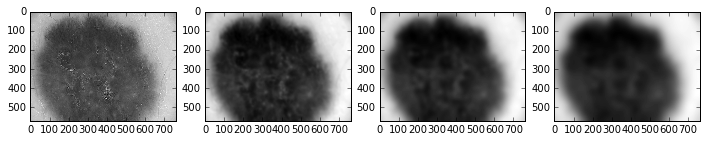

In [13]:
from PIL import Image
from numpy import *
from scipy.ndimage import filters

im = array(Image.open(all_images[22]).convert('L'))
im2 = zeros(im.shape)
images = []

fig = plt.figure(figsize=(12,5), dpi=288) #set figure size
for i in range(4):
    images.append( uint8(filters.gaussian_filter(im, 5*i)) )

    index = 141 + i

    plt.subplot(index)
    imshow(images[i])

*** Image Derivatives ***

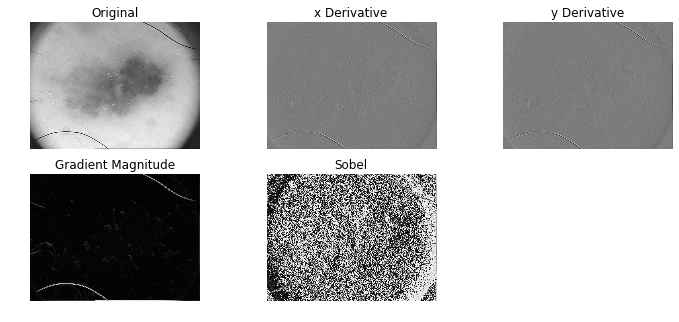

In [14]:
from PIL import Image
from numpy import *
from scipy.ndimage import filters

im = array(Image.open(all_images[64]).convert('L'))
im2 = zeros(im.shape)
images = []

fig = plt.figure(figsize=(12,5), dpi=288) #set figure size
plt.subplot(231)
title('Original')
axis('off')
imshow(im)

imx = zeros(im.shape)
imy = zeros(im.shape)
filters.sobel(im, 1, imx)
filters.sobel(im, 0, imy)
magnitude = sqrt(imx**2+imy**2)

plt.subplot(232)
title('x Derivative')
axis('off')
imshow(imx)

plt.subplot(233)
title('y Derivative')
axis('off')
imshow(imx)

plt.subplot(234)
title('Gradient Magnitude')
axis('off')
imshow(magnitude)

plt.subplot(235)
title('Sobel')
axis('off')
imshow(filters.sobel(im))

show()

** Hair Removal Experiment**

Use the gradient magnitude of an image as the mask of "blur filter"

The "blur filter" will be a Median filter according to "Automatically Early Detection of Skin Cancer: Study Based on Neural Network Classification" 2009. I didn't like this technique because it seemed to me that it was blurring too much details that might be important. Maybe it would be possible to selectivly blur only those areas that appear to be quite prominent in the results of the Grandient Magnitude function above.

The "Blur filter's" mask is run through an adaptive threshold in oder to make it more binary.

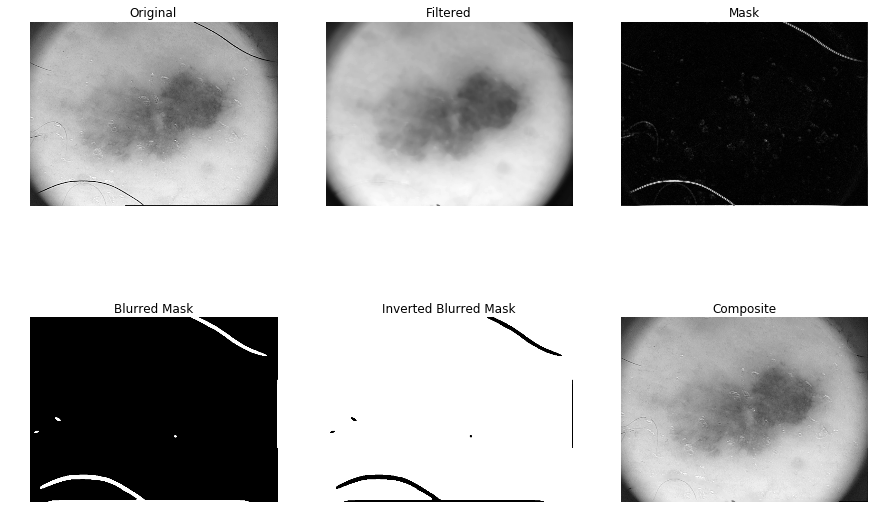

In [125]:
from PIL import Image
from skimage.filters.rank import median
from skimage.morphology import disk
from skimage.filters import threshold_otsu, threshold_adaptive

from numpy import *
from scipy.ndimage import filters

im = array(Image.open(all_images[64]).convert('L'))
fig = plt.figure(figsize=(15,15), dpi=288) #set figure size

plt.subplot(331)
title('Original')
axis('off')
imshow(im)

plt.subplot(332)
title('Filtered')
axis('off')
filtered = filters.median_filter(im, 12)
imshow(filtered)

plt.subplot(333)
title('Mask')
imx = zeros(im.shape)
imy = zeros(im.shape)
filters.sobel(im, 1, imx)
filters.sobel(im, 0, imy)
mask = sqrt(imx**2+imy**2)
axis('off')
imshow(mask)

plt.subplot(334)
title('Blurred Mask')
mask = filters.gaussian_filter(mask, 4)

mask = mask / mask.max()
thresh = threshold_otsu(mask)
mask = mask > thresh
imshow(mask)
axis('off')

plt.subplot(335)
title('Inverted Blurred Mask')
inv_mask = (1.0 - mask)
imshow(inv_mask)
axis('off')

plt.subplot(336)
title('Composite')
comp = (im * (inv_mask)) + (filtered * mask)
imshow(comp)
axis('off')
show()

TODO: The above works well for this particular image. Need to fiddle with the parameters more to find a good general rule.

** Hair Removal Function **

Based on the experiment abover create a general function for hair removal

In [144]:
from scipy.ndimage import filters
from skimage.filters import threshold_otsu

def create_mask(im):
    imx = zeros(im.shape)
    imy = zeros(im.shape)
    filters.sobel(im, 1, imx)
    filters.sobel(im, 0, imy)
    mask = sqrt(imx**2+imy**2)
    mask = mask / mask.max()
    mask = filters.gaussian_filter(mask, 4)
    thresh = threshold_otsu(mask)
    mask = mask > thresh
    return mask


def hair_removal(im, img_filter_amount=10):
    # create filtered image
    filtered = filters.median_filter(im, img_filter_amount)
    
    # create filter mask
    mask = create_mask(im)
    
    # inverse mask
    inv_mask = (1.0 - mask)
    
    comp = (im * (inv_mask)) + (filtered * mask)
    return comp, mask

Testing the function on more images

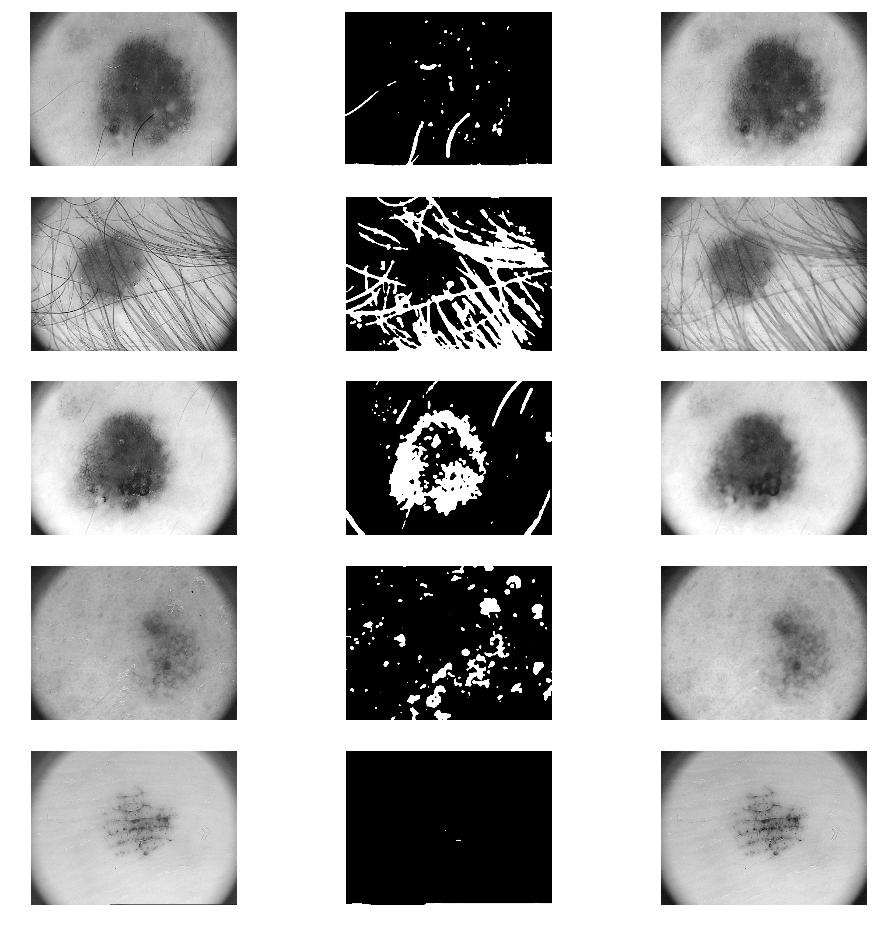

In [166]:
fig = plt.figure(figsize=(16,16), dpi=288) #set figure size

to_display = 5

for i in range(to_display):
    index = 1 + (i*(3))
    plt.subplot(to_display,3,index)
    axis('off')
    im = array(Image.open(all_images[i]).convert('L'))
    imshow(im)
    
    proc_im, mask = hair_removal(im, 10)
    plt.subplot(to_display,3,index + 1)
    axis('off')
    imshow(mask)
    
    plt.subplot(to_display,3,index + 2)
    axis('off')
    imshow(proc_im)

Hair Removal Function using Canny Edge Detector

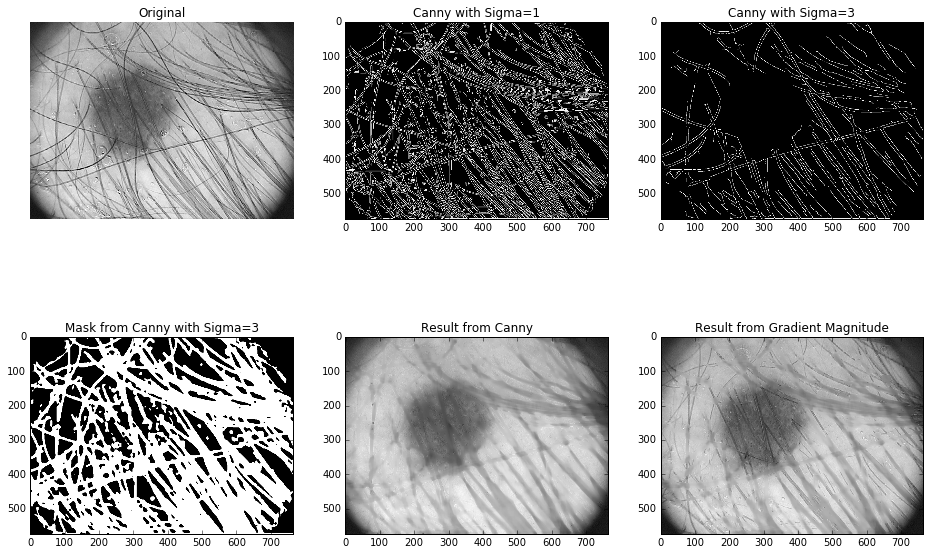

In [161]:
from skimage import feature

fig = plt.figure(figsize=(16,16), dpi=288) #set figure size
im = array(Image.open(all_images[1]).convert('L'))

plt.subplot(331)
title('Original')
axis('off')
imshow(im)

edges1 = feature.canny(im, sigma=1)
edges2 = feature.canny(im, sigma=3)

plt.subplot(332)
imshow(edges1)
title('Canny with Sigma=1')

plt.subplot(333)
imshow(edges2)
title('Canny with Sigma=3')

plt.subplot(334)
mask = edges1 / edges1.max()
mask = filters.gaussian_filter(mask, 3)
thresh = threshold_otsu(mask)
mask = mask > thresh

title('Mask from Canny with Sigma=3')
imshow(mask)

filtered = filters.median_filter(im, 15)

# inverse mask
inv_mask = (1.0 - mask)
    
comp = (im * (inv_mask)) + (filtered * mask)

plt.subplot(335)
title('Result from Canny')
imshow(comp)

# compare with filter above
c, m = hair_removal(im, 15)
plt.subplot(336)
title('Result from Gradient Magnitude')
imshow(c)

show()

Difficult when there are lots of hair. The median-blurred version of the image wich is super imposed onto the original has become darker due to more "bushells" of dark hair blurring with the surrounding area. This is not a problem when dealing with single hair strands. Some sort of brightness equalizsation algorithm might solve this, might also lead to more information loss as well though.


The Cany edge detection algorithm uses Sobel